# Rail state

In this notebook we estimate the covariance matrix of the rail state produced by the feedback loop described in ["On-demand photonic entanglement synthesizer"](https://arxiv.org/abs/1811.10704) by Takeda et al.

In [10]:
from phase_scan import gaussian_utils
from phase_scan.ml_estimation import ml_covariance_estimation
from phase_scan.utils import triangle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import scipy as sp

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

## Computation of the covariance matrix

In [11]:
def compute_covariance_matrix(
    squeezing_dB: float,
    T: float = (np.sqrt(5) - 1) / 2,
    phase_shift: float = np.pi / 2,
    history: int = 15,
    num_iterations: int = 100
) -> np.ndarray:
    """
    Computes the covariance matrix for a rail state produced by feedback.

    Args:
        squeezing_dB (float): Squeezing level of the input vacuum squeezed state, in decibels (dB).
        T (float, optional): Transmittance of the beam splitter. Defaults to (sqrt(5) - 1) / 2.
        phase_shift (float, optional): Phase shift in the delay loop, in radians. Defaults to pi/2.
        history (int, optional): Number of output states to keep track of. Defaults to 15.
        num_iterations (int, optional): Number of iterations to compute the stable state of the loop. Defaults to 100.

    Returns:
        np.ndarray: The computed covariance matrix representing the final rail state.
    """
    history = int(np.round((history + 1) / 4)) * 4 - 1
    
    squeezing_s = 10 ** (-squeezing_dB / 10)
    eye = np.eye(2, 2)

    R = sp.linalg.block_diag(gaussian_utils.rotation_symplectic(phase_shift), eye)
    BS = gaussian_utils.bs_symplectic(T)
    BS_R = BS@R

    symplectic = sp.linalg.block_diag(*([eye] * history + [BS_R]))

    sigma = sp.linalg.block_diag(*([gaussian_utils.vacuum()]*(history + 2)))
    for i in range(num_iterations):
        # Shift mode history and introduce a new squeezed state
        sigma = sp.linalg.block_diag(sigma[2:, 2:], gaussian_utils.squeezed_vacuum(squeezing_s))
        # Apply BS and phase shift
        sigma = symplectic@sigma@symplectic.T

    full_sigma = sigma[:-2, :-2]
    sub_sigma = full_sigma[:6, :6]
    return full_sigma, sub_sigma

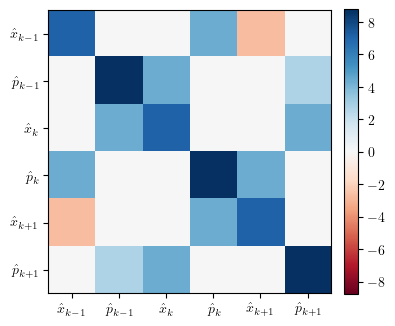

In [12]:
full_sigma, sub_sigma = compute_covariance_matrix(12)
gaussian_utils.plot_covariance_matrix(sub_sigma, show_var_names=True, sequential=True)
plt.show()

## Generation of quadrature samples

These samples correspond to a switching measurement in which we alternate between measuring the $x$ and $p$ quadratures. This requires locking and fast modulation of the LO phase. Note that if this alternated quadrature measurement is possible, samples from the nullifier can be obtained - confirming the expected entanglement structure.

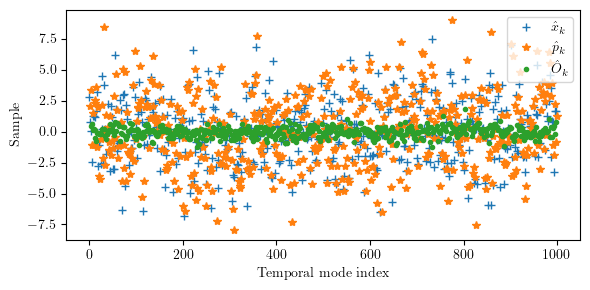

In [7]:
samples = gaussian_utils.generate_samples_sequential(full_sigma, 1000)
x, p = samples[::2], samples[1::2]
pk = p[1:-1]
xkm1 = x[:-2]
xkp1 = x[2:]
nullifier = pk - xkm1 - xkp1

v_nullifier = np.var(nullifier)

t = np.arange(len(samples))
plt.figure(figsize=(6, 3))
plt.plot(t[::2], x, 'C0+', label='$\\hat{x}_k$')
plt.plot(t[1::2], p, 'C1*', label='$\\hat{p}_k$')
plt.plot(t[3:-1:2], nullifier, 'C2.', label='$\\hat{O}_k$')
plt.legend(loc='upper right')
plt.xlabel('Temporal mode index')
plt.ylabel('Sample')
plt.tight_layout()
plt.show()

## Quadrature samples obtained by scanning

Instead of rapidly switching from one observable to another, we can slowly modulate the LO phase to acquire a slowly rotating quadrature. The correlation between temporal modes changes slowly.

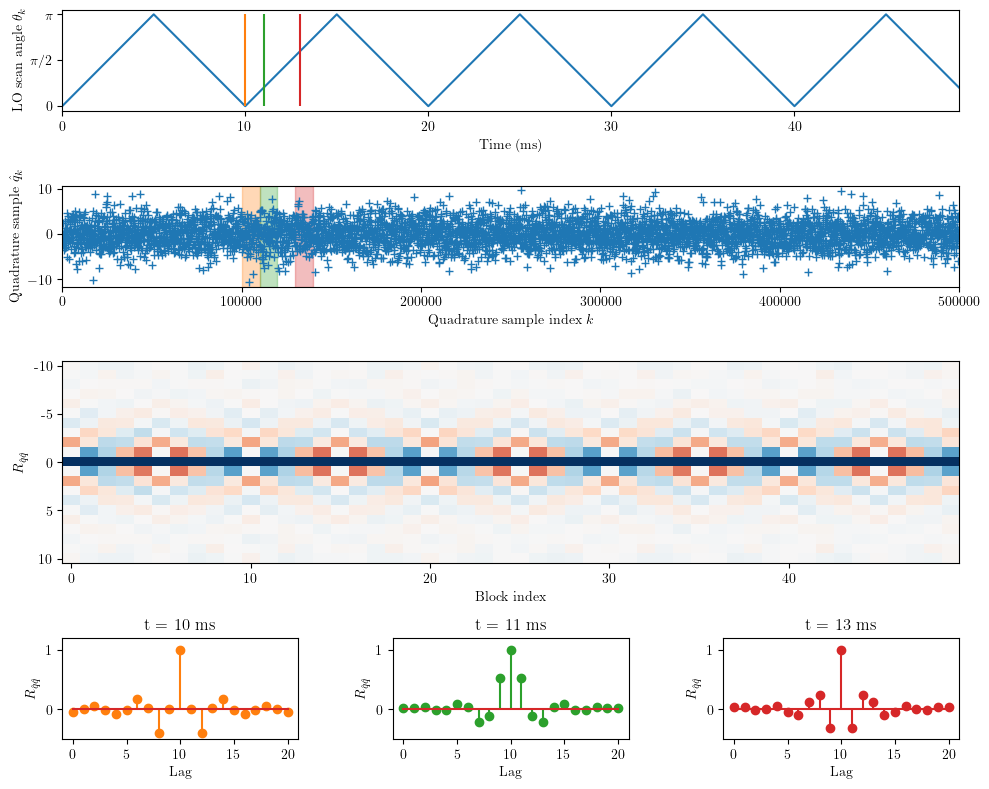

In [13]:
N_angles = 50
t = np.arange(N_angles) / N_angles * 50
angles = np.pi * triangle(t / 50, 5)
full_sigma, _ = compute_covariance_matrix(12)
data = gaussian_utils.generate_scanned_samples(
    full_sigma,
    angles,
    gaussian_utils.generate_samples_sequential,
    samples_per_angle=10000)


fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 2, 1], figure=fig, hspace=0.5)

axs = [fig.add_subplot(gs[i, 0]) for i in range(3)]

axs[0].plot(t, angles)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('LO scan angle $\\theta_k$')
axs[0].set_xlim([0, max(t)])
axs[0].set_yticks([0, np.pi / 2, np.pi], ['0', '$\\pi / 2$', '$\\pi$'])

all_samples = np.concatenate([samples for _, samples in data])
indices = np.arange(len(all_samples))
axs[1].plot(indices[::100], all_samples[::100], '+')
axs[1].set_xlabel('Quadrature sample index $k$')
#axs[1].set_ylabel('$\\hat{q}_k = \\hat{x}_k\\cos \\theta_k + \\hat{x}_k\\sin \\theta_k$')
axs[1].set_ylabel('Quadrature sample $\\hat{q}_k$')
axs[1].set_xlim([0, len(all_samples)])

acf_N = 20
acf_map = np.zeros((N_angles, acf_N + 1))
for i, (_, samples) in enumerate(data):
    sf = np.fft.rfft(samples)
    acf = np.fft.irfft(np.abs(sf) ** 2)
    acf = np.fft.fftshift(acf)
    n = len(acf) // 2
    acf = acf[n - acf_N // 2:n + acf_N // 2 + 1]
    acf_map[i, :] = acf / acf.max()

max_v = np.max(acf_map)
axs[2].imshow(acf_map.T, cmap='RdBu', vmin=-max_v, vmax=max_v, aspect='auto', interpolation='nearest')
axs[2].set_xlabel('Block index')
axs[2].set_ylabel('$R_{\\hat{q} \\hat{q}}$')
axs[2].set_yticks(np.arange(0, acf_N + 1, 5), np.arange(-acf_N // 2, acf_N // 2 + 1, 5))

gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[3], wspace=0.4)
bottom_axs = [fig.add_subplot(gs_bottom[0, i]) for i in range(3)]

for i, t_index in enumerate([10, 11, 13]):
    block_samples = data[t_index][1]
    times = np.linspace(t[t_index], t[t_index + 1], len(block_samples))
    axs[0].vlines(t_index, 0, np.pi, f'C{i + 1}')
    axs[1].axvspan(10_000*t[t_index], 10_000*t[t_index + 1], color=f'C{i + 1}', alpha=0.3)
    bottom_axs[i].stem(acf_map[t_index], f'C{i + 1}')
    bottom_axs[i].set_xlabel('Lag')
    bottom_axs[i].set_ylabel('$R_{\\hat{q} \\hat{q}}$')
    bottom_axs[i].set_ylim([-0.5, 1.2])
    bottom_axs[i].set_title(f't = {int(times[0])} ms')

gs.tight_layout(fig)
plt.show()

## Covariance matrix reconstruction

The covariance matrix can now be reconstructed from the quadrature data.

Optimizing...:   0%|          | 0/2000 [00:00<?, ?it/s]

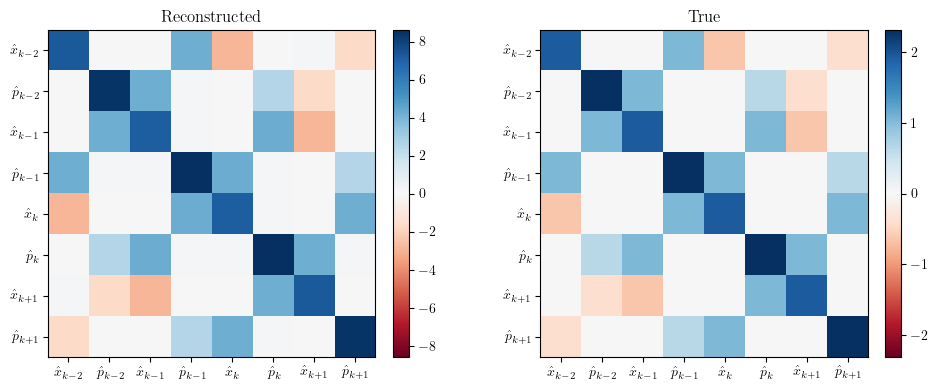

In [9]:
N_angles = 50
angles = np.pi * np.arange(N_angles) / N_angles

data = gaussian_utils.generate_scanned_samples(
    full_sigma,   
    angles,
    gaussian_utils.generate_samples_sequential,
    samples_per_angle=1_000)

estimated_sigma = ml_covariance_estimation(
    gaussian_utils.collect_adjacent_samples(data, 4),
    lr=0.05,
    max_iterations=2_000)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
full_sigma, _ = compute_covariance_matrix(6)
gaussian_utils.plot_covariance_matrix(
    full_sigma[:8, :8], title='True', show_var_names=True, sequential=True, axs=axs[1])
gaussian_utils.plot_covariance_matrix(
    estimated_sigma, title='Reconstructed', show_var_names=True, sequential=True, axs=axs[0]) 
plt.tight_layout()
plt.show()